In [4]:
import sys
sys.path.append('/huge/users/anuj/deep')
from utils import *
from data import *

/home/windborne/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [14]:
import numpy as np
a = np.load(f'/fast/proc/era5_daily/extra/179_ttr/2020/20200102.npz')['x']
norm = np.load(f'/fast/consts/normalization.pickle', allow_pickle=True)
norm['179_ttr']
#a.min(), a.max()

(array([-862238.8125]), array([2.68130918e+10]))

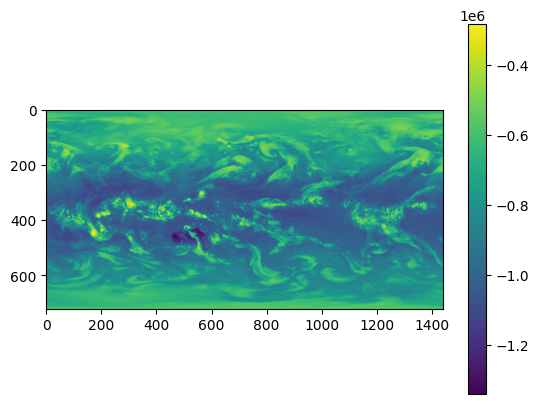

In [17]:
nc = Dataset(f'/huge/proc/raw_era5/202401/e5.oper.an.sfc.128_136_tcw.ll025sc.2024010100_2024013123.nc')
plt.imshow(nc.variables['TCW'][0,:720,:])
plt.colorbar()
plt.show()

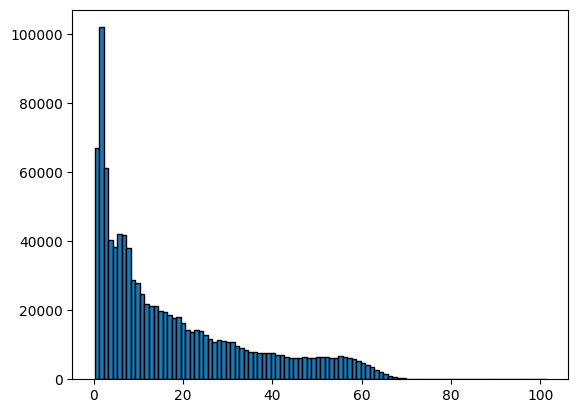

In [25]:
data = nc.variables['TCW'][0,:720,:]
plt.hist(data.flatten(), bins=100, edgecolor='black')
plt.show()

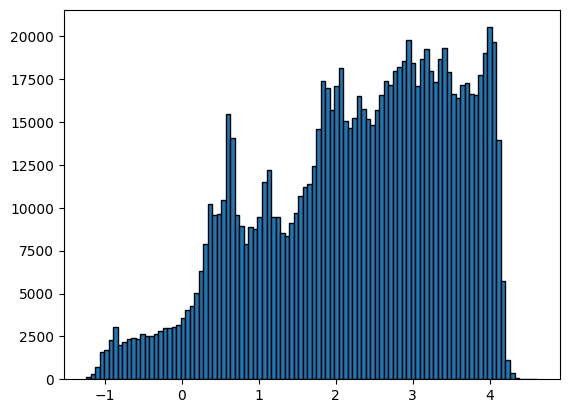

In [26]:
log_tcwv = np.log(np.maximum(data, 1e-7))
plt.hist(log_tcwv.flatten(), bins=100, edgecolor='black')
plt.show()

/home/windborne/.local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


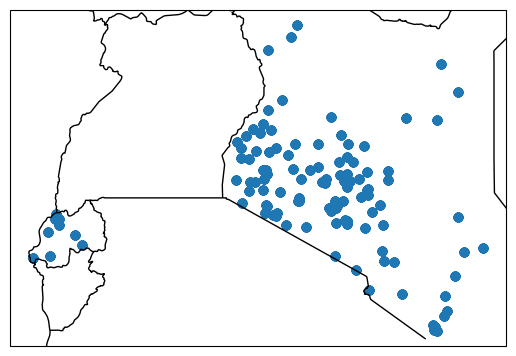

In [6]:
# plot list of lats and longs on map
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import numpy as np
# read tab separated file of lats and longs
lats, longs = np.loadtxt('/huge/users/anuj/deep/norm/tahmo_2023.xml', delimiter='\t', unpack=True)

# plot on map with country borders
import cartopy.feature as cfeature

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS)
plt.scatter(longs, lats)
plt.show()


In [ ]:
dt = datetime(2024, 1,3)
fn = get_raw_nc_filename("034_sstk", dt)
nc = Dataset(fn)
# select utc_date == dt
nc = nc.sel(utc_date=dt.strftime('%Y%m%d%H'))

npy = np.load(f'/fast/proc/era5/extra/034_sstk/202401/{dt.timestamp()}.npz')['x']
with open(f"/fast/consts/normalization.pickle", "rb") as f:
    norm = pickle.load(f)
npy = npy*np.sqrt(norm['034_sstk'][1])+norm['034_sstk'][0]
nc.shape

In [31]:
# read grib
import pygrib
import pickle
import numpy as np
from datetime import datetime, timedelta
import sys
sys.path.append('/huge/users/anuj/deep')
from utils import core_sfc_vars, log_vars
from eval import eval_metrics_sfc
from scipy.interpolate import griddata

def load_era5_daily(variable, timestamp):
    """Load ERA5 daily data for a specific variable and timestamp."""
    date_str = timestamp.strftime("%Y%m%d")
    year_str = timestamp.strftime("%Y")
    
    if variable in core_sfc_vars: 
        path = f'/fast/proc/era5_daily/f000/{year_str}/{date_str}.npz'
        data = np.load(path)['sfc']
        data = data[:, :, core_sfc_vars.index(variable)]  
    else:  # extra surface variables
        path = f'/fast/proc/era5_daily/extra/{variable}/{year_str}/{date_str}.npz'
        data = np.load(path)['x']
        data = data[0] if data.ndim == 3 else data
    with open(f"/fast/consts/normalization.pickle", "rb") as f:
        norm = pickle.load(f)
        mean, std = norm[variable][0], np.sqrt(norm[variable][1])
    data = data * std + mean
    if variable in log_vars:
        data = np.exp(data)
    return data
    
results = {}
lats = np.arange(90, -90, -1.5) 
lats = np.repeat(lats, 240).reshape(120,240)
weights = np.cos(lats * np.pi/180) 
s2s_var_mapping = {
        '2 metre temperature': '167_2t',
        '2 metre dewpoint temperature': '168_2d',
        'Sea surface temperature': '034_sstk', # need to account for nans
        'Total column water': '136_tcw',
        'Total Cloud Cover': '45_tcc',
    }

In [51]:
sst_grib = None
grbs = pygrib.open('/huge/proc/s2s/ecmf/rt/daily/202001.grib')
for grb in grbs:
    if grb.name == 'Sea surface temperature':
        sst_grib = grb.values
        break
sst_grib

masked_array(
  data=[[271.4599609375, 271.4599609375, 271.4599609375, ...,
         271.4599609375, 271.4599609375, 271.4599609375],
        [271.4619140625, 271.4619140625, 271.4619140625, ...,
         271.4599609375, 271.4619140625, 271.4619140625],
        [271.4609375, 271.4599609375, 271.4599609375, ..., 271.4609375,
         271.4599609375, 271.4599609375],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=9999.0)

In [70]:
from evals import *
from utils import *
import pytz
cache = {}

def get_model_scores(model,var,dt=24,vs='era5_daily-28',metric='rmse'):
    global cache
    dates = []
    vars = []
    for fn in sorted(os.listdir(get_errors_path(model))):
        fns = fn.split('.')
        if len(fns) < 3: continue
        if not fns[0].endswith(f'+{dt}') or fns[1] != 'vs_'+vs or fns[2] != 'json':
            continue
        pp = get_errors_path(model)+fn
        if pp in cache:
            j = cache[pp]
        else:
            with open(pp,'r') as f:
                j = json.load(f)
            cache[pp] = j
        rms = j[metric]
        date = datetime.strptime(fn.split('+')[0],'%Y%m%d%H').replace(tzinfo=timezone.utc)
        if (date >= datetime(2020,1,1,tzinfo=pytz.utc) and date <= datetime(2022,12,31,tzinfo=pytz.utc)) or "rtyblong" in model:
            dates.append(date)
            vars.append(rms[var])
    # sort both dates and vars by dates
    if len(dates) == 0:
        return None, None
    #assert len(dates) > 0, f"No dates found for {model} {var} {dt}"
    dates, vars = zip(*sorted(zip(dates, vars)))
    return dates, vars

metric = 'rmse'
NDAY = 45
dts = np.arange(0,NDAY+1)*24
v = '167_2t'
for modelname in ['thor']:
    def get_avg_rms(dt):
        s = get_model_scores(modelname,v,dt=dt,metric=metric)
        if s[0] is None:
            return None
        rms = np.array(sorted(s[1]))
        rms = rms[3:-3] # remove few outliers
        return np.mean(np.square(rms))**0.5
    
    rms = np.array([get_avg_rms(dt) for dt in dts if get_avg_rms(dt) is not None])

In [82]:
# save rms to json
import json
modelname = 'thor'
variable = '167_2t'
grid_resolution = 0.25
start_date = datetime(2020,1,1).strftime("%Y%m%d")
end_date = datetime(2020,12,31).strftime("%Y%m%d")
errors_proc_dir = f'/huge/deep/evaluation/{modelname}/errors_proc/{grid_resolution}deg/{start_date}-{end_date}'
os.makedirs(errors_proc_dir, exist_ok=True)
out = {}
out['variable'] = variable
out['start_date'] = start_date
out['end_date'] = end_date
out['grid_resolution'] = grid_resolution
out['model_type'] = modelname
out['comparison_source'] = 'era5_daily'
out['rmse'] = {str(dt): rms[i] for i, dt in enumerate(dts)}

with open(f'{errors_proc_dir}/{variable}.json', 'w') as f:
    json.dump(out, f)

In [11]:
# check daily averaged log vars
import numpy as np
var = '136_tcw'
daily = np.load(f'/fast/proc/era5_daily/extra/{var}/2020/20200102.npz')['x']
#daily = np.load(f'/fast/proc/era5_daily/f000/2020/20200102.npz')['sfc'][:,:,3]
avg = np.zeros_like(daily)
for i in range(24):
    ts = 1577923200+i*3600
    avg += np.load(f'/fast/proc/era5/extra/{var}/202001/{ts}.npz')['x']
    #avg += np.load(f'/fast/proc/era5/f000/202001/{ts}.npz')['sfc'][:,:,3]
avg = avg/24

print(np.sqrt(np.mean((daily-avg)**2)))
daily, avg


0.023607113288289246


(array([[[-2.10479285, -2.10479285, -2.10479285, ..., -2.10479285,
          -2.10479285, -2.10479285],
         [-2.12731199, -2.12670904, -2.12652667, ..., -2.1283151 ,
          -2.12803316, -2.12765358],
         [-2.14628299, -2.145422  , -2.1445577 , ..., -2.14850906,
          -2.14767629, -2.14711932],
         ...,
         [-2.52837226, -2.52844634, -2.52866669, ..., -2.52853901,
          -2.52845589, -2.52845589],
         [-2.55649224, -2.55686301, -2.55677769, ..., -2.55625145,
          -2.55625145, -2.55641314],
         [-2.5742104 , -2.5742966 , -2.57437876, ..., -2.57422593,
          -2.5742966 , -2.5742966 ]]]),
 array([[[-2.14241536, -2.14241536, -2.14241536, ..., -2.14241536,
          -2.14241536, -2.14241536],
         [-2.16556803, -2.16503906, -2.1648763 , ..., -2.16642253,
          -2.16617839, -2.16589355],
         [-2.18115234, -2.18033854, -2.17952474, ..., -2.18302409,
          -2.18229167, -2.18192546],
         ...,
         [-2.52970378, -2.5297851

In [18]:
# load normalization
import pickle
with open(f"/fast/consts/normalization.pickle", "rb") as f:
    norm = pickle.load(f)
norm['201_mx2t']


(array([287.90871428]), array([232.12284349]))

In [5]:
#nc = Dataset(get_raw_nc_filename("034_sstk", datetime(2024, 1,3)))
nc['utc_date'][21:25].data
nc['SSTK'][21:25,360,720].data


NameError: name 'nc' is not defined

In [3]:
data[:,0,301,600]

array([301.67114, 301.67114, 301.67114, 301.67114, 301.67114, 301.67114,
       301.67114, 301.67114, 301.67114, 301.67114, 301.67114, 301.67114,
       301.67114, 301.67114, 301.67114, 301.67114, 301.67114, 301.67114,
       301.67114, 301.67114, 301.67114, 301.67114, 301.6067 , 301.6067 ,
       301.6067 , 301.6067 , 301.6067 , 301.6067 , 301.6067 , 301.6067 ,
       301.6067 , 301.6067 , 301.6067 , 301.6067 , 301.6067 , 301.6067 ,
       301.6067 , 301.6067 , 301.6067 , 301.6067 , 301.6067 , 301.6067 ,
       301.6067 , 301.6067 , 301.6067 , 301.6067 , 301.6709 , 301.6709 ,
       301.6709 , 301.6709 , 301.6709 , 301.6709 , 301.6709 , 301.6709 ,
       301.6709 , 301.6709 , 301.6709 , 301.6709 , 301.6709 , 301.6709 ,
       301.6709 , 301.6709 , 301.6709 , 301.6709 , 301.6709 , 301.6709 ,
       301.6709 , 301.6709 , 301.6709 , 301.6709 , 301.60913, 301.60913,
       301.60913, 301.60913, 301.60913, 301.60913, 301.60913, 301.60913,
       301.60913, 301.60913, 301.60913, 301.60913, 

In [3]:
import numpy as np
ts = 1704240000 # 2024-01-03 0zimport numpy as np

a = np.load(f'/fast/proc/era5/f000/200801/1199145600.npz')
a['sfc'].shape, a['pr'].shape


((720, 1440, 4), (720, 1440, 5, 28))

In [1]:
import matplotlib.pyplot as plt
import numpy as np
ts = 1704240000 # 2024-01-03 0zimport numpy as np

a = np.load(f'/fast/proc/era5/extra/034_sstk/202401/{ts}.npz')['x']
b = np.load(f'/fast/proc/era5/extra/034_sstk/202401/{ts+3600}.npz')['x']
c = np.load(f'/fast/proc/era5/extra/034_sstk/202401/{ts-3600}.npz')['x']


In [4]:
a = np.array(a)
a[np.isnan(a)] = 0
b = np.array(b)
b[np.isnan(b)] = 0
indices = np.where(~np.isclose(a, b, rtol=1e-2))
a[indices], b[indices]

(array([-0.172   , -0.2104  ,  0.0252  , -0.0325  ,  0.04153 ,  0.2306  ,
         0.2319  ,  0.2323  ,  1.051   ,  0.2335  ,  0.2808  ,  0.2474  ,
         1.191   ,  1.196   ,  1.073   ,  1.221   ,  1.271   ,  1.238   ,
         1.207   ,  1.251   ,  1.232   ,  1.204   ,  1.212   ,  1.186   ,
         0.2546  ,  1.189   ,  1.212   ,  1.044   ,  1.044   ,  1.044   ,
         1.044   ,  1.131   ,  1.131   ,  1.136   ,  1.071   ,  1.133   ,
         1.109   ,  0.8276  ,  0.9766  ,  0.7764  ,  0.7764  ,  0.8027  ,
         0.7935  ,  0.805   ,  1.062   ,  1.061   ,  0.7866  ,  0.7827  ,
         0.799   ,  0.815   ,  0.815   ,  0.8164  ,  0.8276  ,  0.864   ,
         1.062   ,  1.062   ,  0.7485  ,  0.7793  ,  0.824   ,  0.826   ,
         0.749   ,  0.8267  ,  0.8364  ,  0.8643  ,  0.7095  ,  0.765   ,
         0.832   ,  0.845   ,  1.288   ,  1.294   ,  1.32    ,  1.055   ,
         0.986   ,  0.8945  ,  0.8438  ,  0.69    ,  0.554   ,  0.557   ,
         1.064   ,  1.064   ,  0.9565 

In [6]:
a = np.array(a)
a[np.isnan(a)] = 0
c = np.array(c)
c[np.isnan(c)] = 0
indices = np.where(~np.isclose(a, c, rtol=1e-2))
a[indices], c[indices]

(array([-0.2104  ,  0.0252  , -0.0325  ,  0.04153 ,  0.2306  ,  0.2319  ,
         0.2323  ,  1.025   ,  1.051   ,  1.041   ,  0.2335  ,  0.2808  ,
         0.2474  ,  1.191   ,  1.196   ,  1.221   ,  1.271   ,  1.238   ,
         1.278   ,  1.263   ,  1.207   ,  1.256   ,  1.251   ,  1.232   ,
         1.156   ,  1.204   ,  1.212   ,  1.186   ,  0.2546  ,  1.212   ,
         1.044   ,  1.044   ,  1.044   ,  1.044   ,  1.131   ,  1.136   ,
         1.071   ,  1.133   ,  1.109   ,  0.9766  ,  0.7764  ,  0.7764  ,
         0.8027  ,  0.7935  ,  0.805   ,  1.062   ,  1.061   ,  0.7866  ,
         0.7827  ,  0.799   ,  0.815   ,  0.8164  ,  0.8276  ,  0.864   ,
         1.062   ,  1.062   ,  0.7485  ,  0.7793  ,  0.809   ,  0.826   ,
         0.873   ,  0.871   ,  0.749   ,  0.801   ,  0.8364  ,  0.8643  ,
         0.7095  ,  0.765   ,  0.845   ,  0.43    ,  0.828   ,  0.5283  ,
         1.294   ,  1.32    ,  1.055   ,  0.986   ,  0.8945  ,  0.8438  ,
         0.705   ,  0.69    ,  0.693  

(array([[90., 52., 50., ..., 81., 42., 27.],
        [90., 52., 51., ..., 80., 44., 25.],
        [93., 51., 50., ..., 80., 45., 25.],
        ...,
        [95., 49., 49., ..., 83., 41., 25.],
        [94., 49., 49., ..., 82., 41., 25.],
        [92., 51., 49., ..., 82., 41., 25.]]),
 array([-2.13085938, -1.78320312, -1.43457031, -1.0859375 , -0.73828125,
        -0.39013672, -0.04199219,  0.30615234,  0.65429688,  1.00195312,
         1.35058594]),
 <a list of 1440 BarContainer objects>)

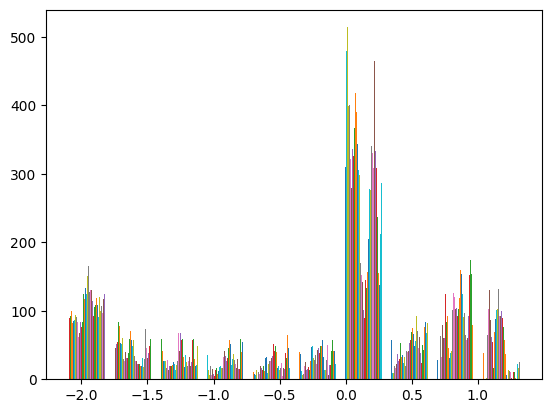

In [8]:
plt.hist(a)

In [10]:
import pickle
with open(f"/fast/consts/normalization.pickle", "rb") as f:
    norm = pickle.load(f)
np.sqrt(norm['034_sstk'][1])

array([10.29116919])

In [3]:
print(a[360,720], b[360,720], c[360,720])

unnorm_sstk = lambda x: x*np.sqrt(norm['034_sstk'][1])+norm['034_sstk'][0]
a = unnorm_sstk(a)
b = unnorm_sstk(b)
c = unnorm_sstk(c)
print(data[0,0,360,720], c)


1.188 1.188 1.188


NameError: name 'data' is not defined

In [30]:
a[360,720], b[360,720], c[360,720]


(303.86887521366276, 303.86887521366276, 303.86887521366276)

TypeError: Invalid shape (772450560,) for image data

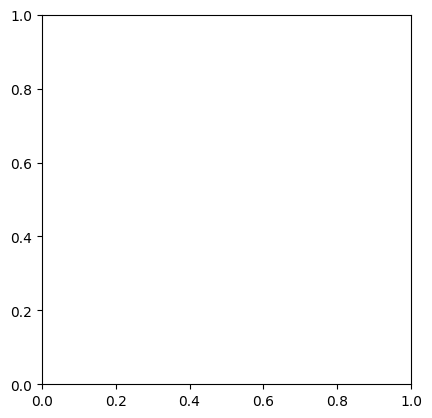

In [43]:
from utils import *
data = get_dataset(get_raw_nc_filename("246_100u", datetime(2006, 3,1)))
#data = np.log(np.maximum(data + 1e-7,0))
f = data.flatten()
plt.imshow(f)
plt.colorbar()
plt.show()
f.min(), f.mean(), np.median(f), f.max(), f.std()
plt.figure(figsize=(8, 4))
plt.hist(f.flatten(), bins=100, edgecolor='black')
plt.ylabel('Frequency')
plt.show()

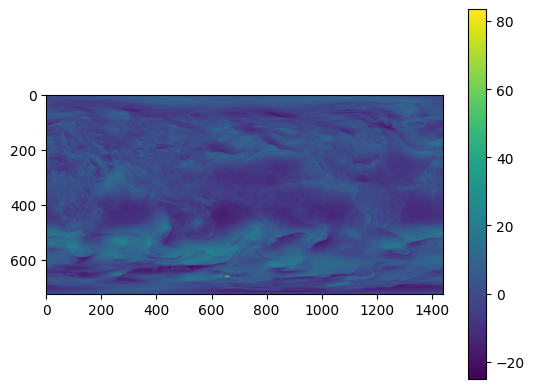

In [42]:
# max index and convert it into 4d index
#ind = np.unravel_index(np.argmax(data), data.shape)
ind
#data[ind]
plt.imshow(data[ind[0]-1,ind[1]])
#plt.imshow(data[497,ind[1]])
plt.colorbar()
plt.show()


In [27]:
# read normalization pickle
with open(f"/fast/consts/normalization.pickle", "rb") as f:
    norm = pickle.load(f)
norm['246_100u']


(array([-0.18640006]), array([45.52258682]))

In [5]:
# a = Dataset(get_raw_nc_filename("246_100u", datetime(2015, 1,1))).variables['VAR_100U'][:]
# a[a>100]
from utils import *
a = get_raw_nc_filename("246_100u", datetime(1987, 1,1))
data = np.array(Dataset(a).variables['VAR_100U'][:])
data[data>100]
# list of datetimes for 1st of each month from 1959 to 2023
#dates = [datetime(year, month, 1) for year in range(2015, 2023) for month in range(1, 13)]
#fns = [get_raw_nc_filename("246_100u", date) for date in dates]

# high_vals = []
# for fn in fns:
#     print(fn)
#     data = get_dataset(fn)
#     if len(data[data>100]) > 0:
#         print(fn + ' ------------------------------------------------' + str(max(data)))
#         high_vals.append((fn, max(data)))
#plt.hist(a.flatten(), bins=100, edgecolor='black')


In [54]:
# from utils import *
#data = Dataset(get_raw_nc_filename("142_lsp", datetime(2015, 1,1)))
# data = np.log(np.maximum(data + 1e-7,0))
a = data['LSP'][:][0,:6].sum(axis=0)
# c1 = (np.log(a+1e-7) - norm['142_lsp-6h'][0])/np.sqrt(norm['142_lsp-6h'][1])
# c1 = c1[:720,:]
c1 = a[:720,:]
c1
# c = a+b
#np.allclose(np.log(a+b), np.log(np.exp(np.log(a)) + np.exp(np.log(b))))

masked_array(
  data=[[2.5272369e-05, 2.5272369e-05, 2.5272369e-05, ..., 2.5272369e-05,
         2.5272369e-05, 2.5272369e-05],
        [2.3365021e-05, 2.3365021e-05, 2.3365021e-05, ..., 2.3365021e-05,
         2.3365021e-05, 2.3365021e-05],
        [2.7656555e-05, 2.7656555e-05, 2.7656555e-05, ..., 2.7656555e-05,
         2.7656555e-05, 2.7656555e-05],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [93]:
norm = np.load('/fast/consts/normalization.pickle', allow_pickle=True)
m = '202207'
d = os.listdir(f'/fast/proc/era5/extra/logtp/{m}')[0]
a = np.load(f'/fast/proc/era5/extra/logtp/{m}/{d}')['x']
b = np.load(f'/fast/proc/era5/extra/142_lsp/{m}/{d}')['x']
c = np.load(f'/fast/proc/era5/extra/143_cp/{m}/{d}')['x']
r1 = np.exp(a*np.sqrt(norm['logtp'][1])+norm['logtp'][0])-1e-7
l1 = np.exp(b*np.sqrt(norm['142_lsp'][1])+norm['142_lsp'][0])-1e-7
l2 = np.exp(c*np.sqrt(norm['143_cp'][1])+norm['143_cp'][0])-1e-7
r2 = l1 + l2
n = 8
lat = 344
lon = 580
r1[lat,lon], l1[lat,lon], l2[lat,lon], r2[lat,lon]


(0.025632583, 0.017887058024787985, 0.00780194699923641, 0.025689005024024394)

In [95]:
m = '202007'
d = os.listdir(f'/fast/proc/era5/extra/logtp/{m}')[0]
e = np.load(f'/fast/proc/era5/extra/15_msnswrf/{m}/{d}')['x']
e.shape

(1, 720, 1440)

In [51]:
np.allclose(c1, c2, rtol=1e-1)

False

In [69]:
# verify aggregation
from utils import *
fn = '/huge/proc/raw_era5/201611/e5.oper.fc.sfc.accumu.128_143_cp.ll025sc.2016110106_2016111606.nc'
data = get_dataset(fn, agg_hours=3)
print(data[0,0,301,600])

ds = Dataset(fn)
np.log(sum(ds.variables['CP'][0,0:3,301,600]))

AssertionError: date_hours must be provided for aggregated variables

In [40]:
# verified mtpr and cp+lsp match
mtpr = Dataset('/huge/proc/raw_era5/202201/e5.oper.fc.sfc.meanflux.235_055_mtpr.ll025sc.2022010106_2022011606.nc')
mtp = mtpr.variables['MTPR'][0,0,:720,:]*60*60/1000
#logmtp = np.log(np.maximum(mtp+1e-7,0))

cp = Dataset('/huge/proc/raw_era5/202201/e5.oper.fc.sfc.accumu.128_143_cp.ll025sc.2022010106_2022011606.nc')
lsp = Dataset('/huge/proc/raw_era5/202201/e5.oper.fc.sfc.accumu.128_142_lsp.ll025sc.2022010106_2022011606.nc')
sum_p = cp.variables['CP'][0,0,:720,:] + lsp.variables['LSP'][0,0,:720,:]

print(sum_p.mean(), sum_p.std())
print(mtp.mean(), mtp.std())
print(np.sqrt(np.mean((sum_p-mtp)**2)))

9.380742e-05 0.0003967742
9.382519457075331e-05 0.00039677048882839634
2.2351742e-07


In [83]:
# verified data from weatherbench matches the logpt we have
import xarray as xr
dataset = xr.open_zarr("gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr")
wb_p = dataset['total_precipitation']

logtp = np.load('/fast/proc/era5/extra/logtp/202201/1640995200.npz')['x']
#logtp = np.exp(logtp*np.sqrt(norm['logtp'][1])+norm['logtp'][0])-1e-7
logtp = logtp*np.sqrt(norm['logtp'][1])+norm['logtp'][0]
ind = (datetime(2022, 1, 1)- datetime(1959, 1, 1)).days*24+6
wb_p = wb_p[ind].to_numpy()[:720,:]
logwb_p = np.log(np.maximum(wb_p+1e-7,0))

print(logwb_p.mean(), logwb_p.std())
print(logtp.mean(), logtp.std())
print(np.sqrt(np.mean((logwb_p-logtp)**2)))

[16:15:31.22|00] -12.643546 3.0186176
[16:15:31.22|00] -12.742442 3.0088704
[16:15:31.22|00] 2.3996587


array([[-0.63  , -0.63  , -0.63  , ..., -0.63  , -0.63  , -0.63  ],
       [-0.22  , -0.309 , -0.309 , ..., -0.309 , -0.309 , -0.309 ],
       [-0.0431, -0.0431, -0.0431, ..., -0.0431, -0.0431, -0.0431],
       ...,
       [ 0.71  ,  0.71  ,  0.71  , ...,  0.7144,  0.7144,  0.71  ],
       [ 0.865 ,  0.865 ,  0.865 , ...,  0.868 ,  0.865 ,  0.865 ],
       [ 0.9805,  0.9805,  0.9805, ...,  0.9824,  0.9824,  0.9805]],
      dtype=float16)

In [71]:
# comparing tcc processed
a = np.load('/fast/proc/era5/extra/45_tcc/202201/1641016800.npz')['x'][0]
b = np.load('/fast/proc/era5_test/extra/45_tcc/202201/1641016800.npz')['x'][0]
rmse = np.sqrt(np.mean((a-b)**2))
assert rmse ==0
a[~np.isclose(a, b, atol=1e-3)], b[~np.isclose(a, b, atol=1e-3)]


(array([], dtype=float16), array([], dtype=float16))

In [1]:
# comparing 168_2d procesed files
import numpy as np
import pickle
#a = np.load('/fast/proc/era5/extra/034_sstk/202201/1641016800.npz')['x'] #[0]
# load normalization and multiply by variance
with open(f"/fast/consts/normalization.pickle", "rb") as f:
    norm = pickle.load(f)

#     a *= np.sqrt(norm['034_sstk'][1])
# rmse = np.sqrt(np.mean((a-b)**2))
# assert rmse ==0
#np.nanmean(a, dtype=np.float32)

{'165_10u': (array([-0.37721445]), array([30.31510883])),
 '166_10v': (array([0.17445794]), array([20.86362823])),
 '167_2t': (array([287.48915052]), array([236.8513564])),
 '168_2d': (array([282.44136889]), array([228.27246109])),
 '151_msl': (array([101139.95543522]), array([1263656.50880973])),
 '129_z': (array([466478.92128472, 414590.75377387, 384976.04775896, 349062.1816961 ,
         326235.86717573, 302603.08635202, 257875.75707082, 232382.93574312,
         200974.34869713, 180777.05448975, 159769.28264375, 146569.76433024,
         135600.15423   , 126157.64435544, 117843.11108615, 110393.38927114,
         103622.87735752,  91612.9583464 ,  81119.14636398,  71754.03853551,
          63278.66237757,  55529.80171856,  48388.26241191,  41762.77757147,
          35579.55233014,  29778.72707175,  24314.31197269,  21696.54855794,
          19149.69867287,  16670.29963072,  14255.37929015,  11901.85000512,
           9606.40417108,   7365.54475456,   5175.844968  ,   3034.44001957,

In [51]:
nan_mask_dict

{'034_sstk': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '034_sstk_fixed': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [11]:
with open(f"/fast/consts/nan_mask.pkl", "rb") as f:
    a = pickle.load(f)
a


{'034_sstk': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [31]:
# comparing core processed files
import numpy as np
a = np.load('/fast/proc/era5/f000/202201/1640995200.npz')['pr']#[0]
b = np.load('/fast/proc/era5_test/f000/202201/1640995200.npz')['pr']#[0]
a.shape,b.shape
# rmse = np.sqrt(np.mean((a-b)**2))
# assert rmse ==0
# a[~np.isclose(a, b, atol=1e-3)], b[~np.isclose(a, b, atol=1e-3)]

((721, 1440, 5, 28), (720, 1440, 5, 28))

In [5]:
# Comparing raw MSL files
ds1 = Dataset('/huge/proc/raw_era5/202201/e5.oper.an.sfc.128_151_msl.ll025sc.2022010100_2022013123.nc')
# ds2 = Dataset('/slow/era5/202201/e5.oper.an.sfc.128_151_msl.ll025sc.2022010100_2022013123.nc')

# #v = ds1.variables['MSL'][:] == ds2.variables['MSL'][:] # verified
ds1.variables['MSL'][:].shape

(744, 721, 1440)